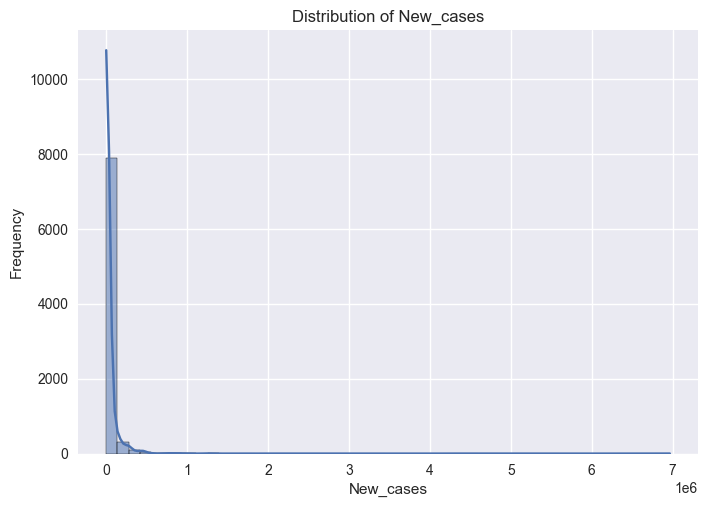

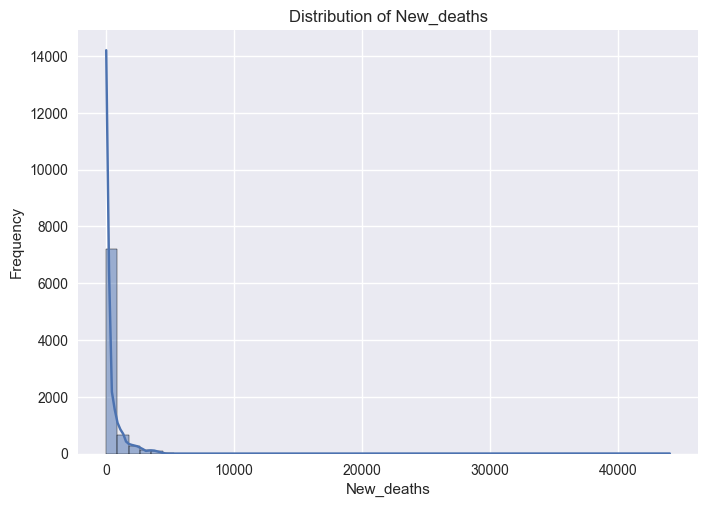

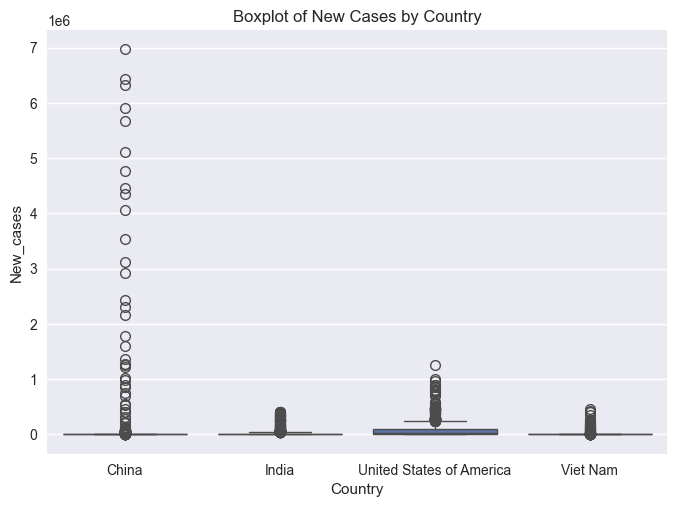

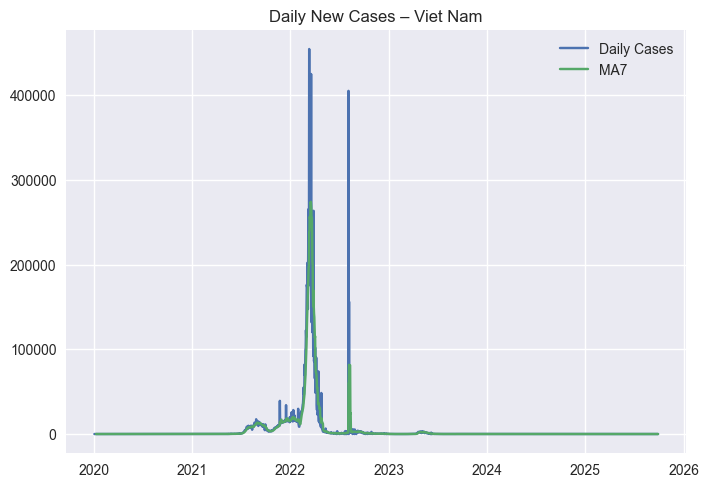

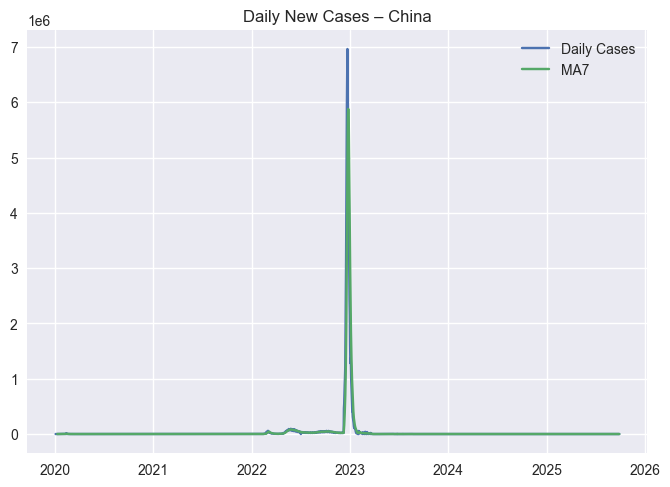

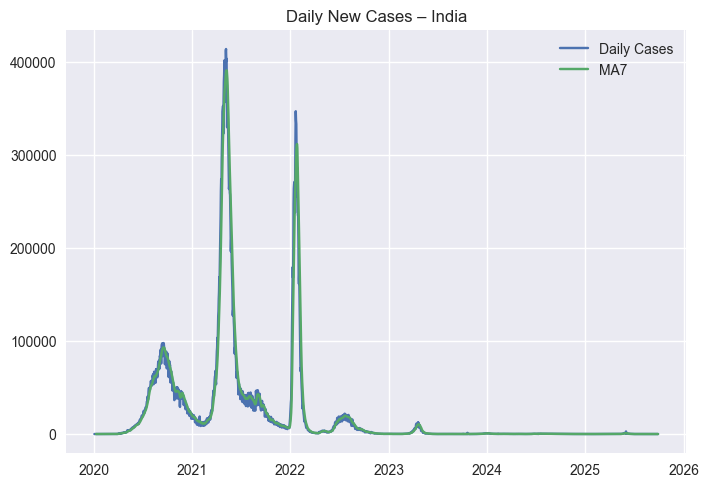

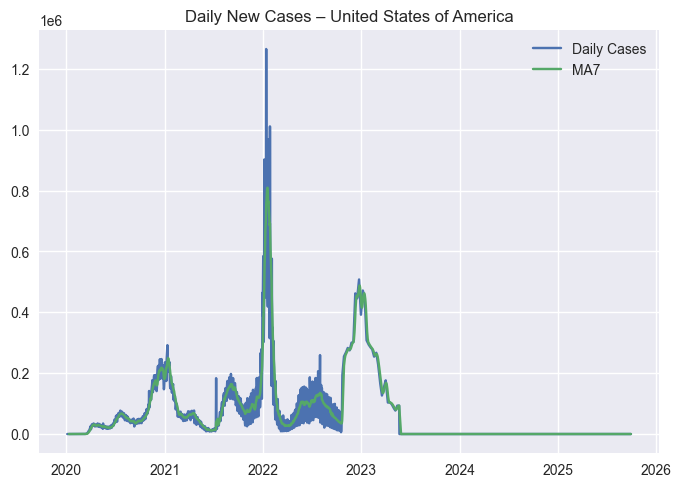

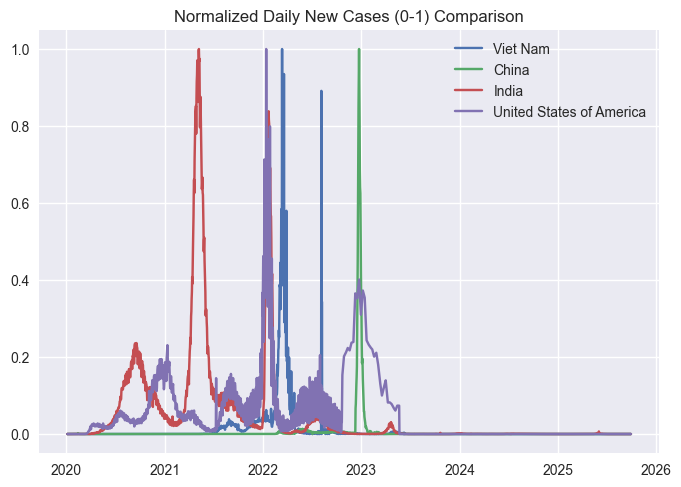

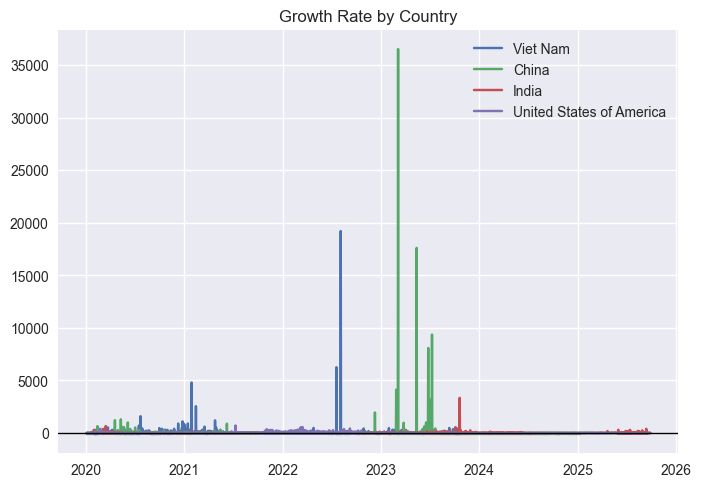

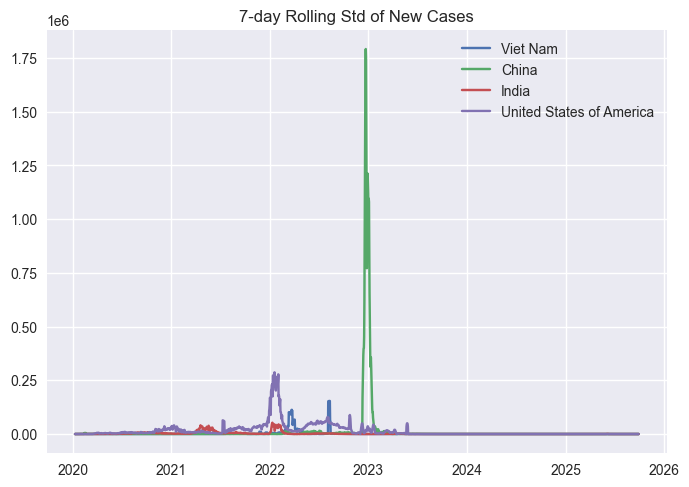

<Figure size 800x550 with 0 Axes>

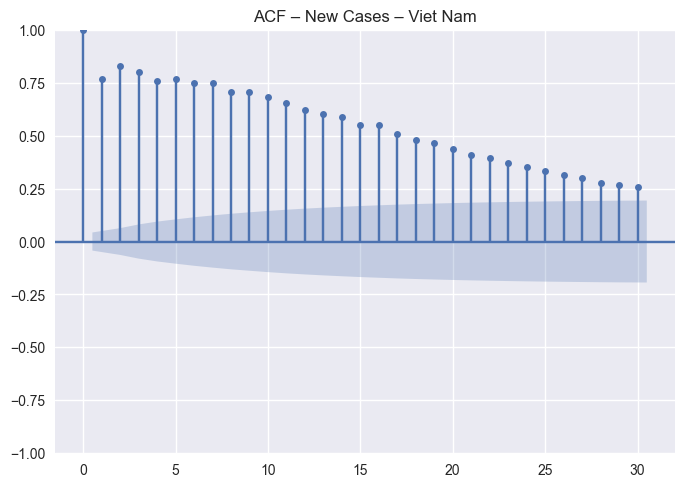

<Figure size 800x550 with 0 Axes>

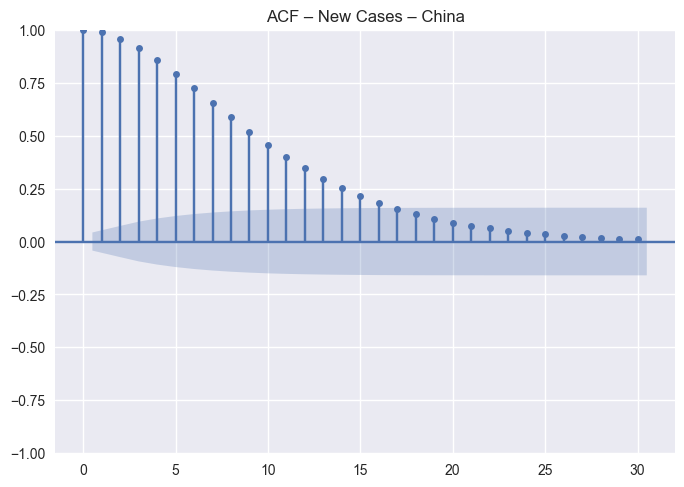

<Figure size 800x550 with 0 Axes>

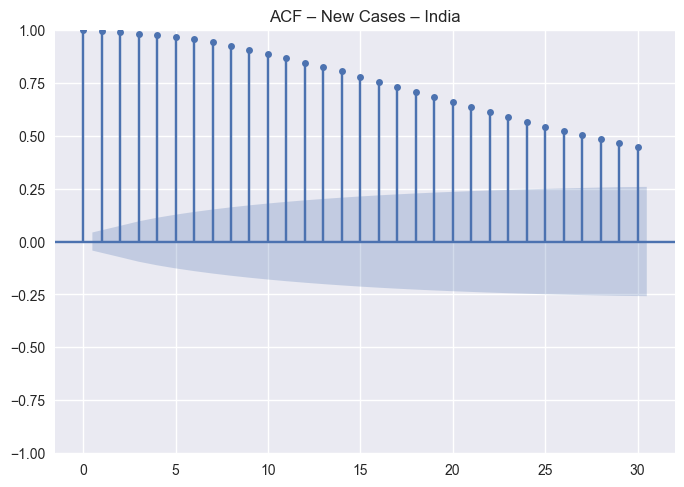

<Figure size 800x550 with 0 Axes>

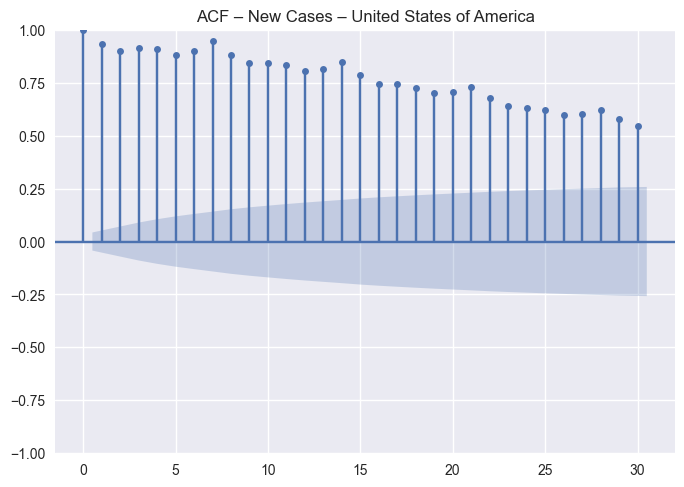

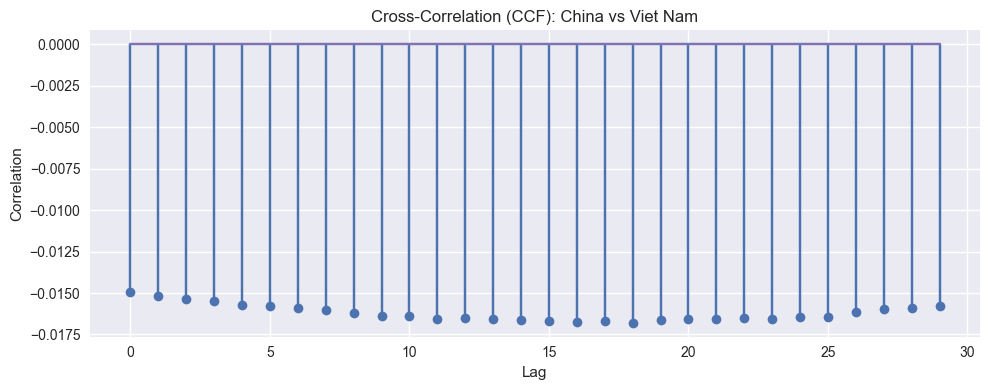

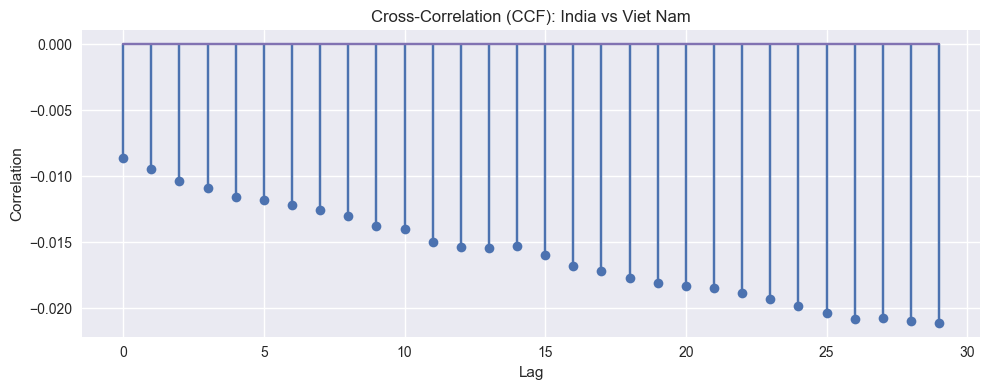

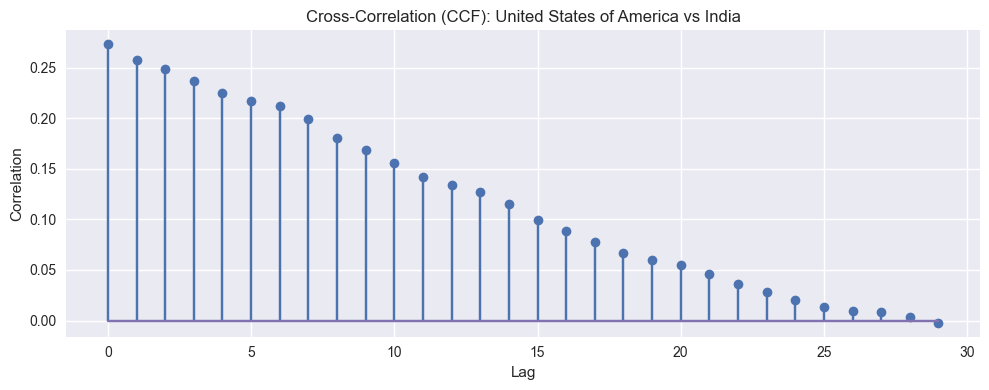

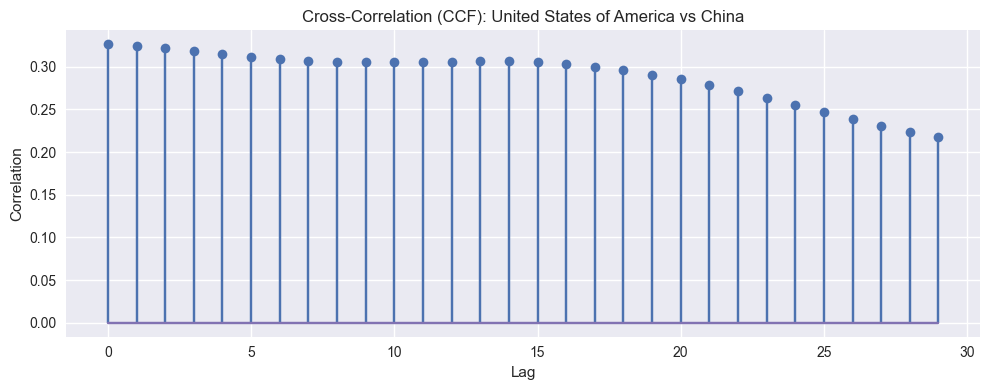

Cluster assignment: {'China': 1, 'India': 0, 'United States of America': 1, 'Viet Nam': 1}


In [3]:
# ============================================================
#            FULL EDA COVID-19 FOR 4 COUNTRIES
#    Viet Nam – China – India – United States of America
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import ccf
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns

plt.rcParams['figure.figsize'] = (12, 6)
plt.style.use('seaborn-v0_8')

# ------------------------------------------------------------
# 1. LOAD DATA
# ------------------------------------------------------------
df = pd.read_csv("../data/processed/01_clean_daily_timeseries.csv.gz", compression="gzip")

countries = ["Viet Nam", "China", "India", "United States of America"]
df = df[df["Country"].isin(countries)].copy()
df = df.sort_values(["Country", "Date_reported"])

# ------------------------------------------------------------
# 2. SET DATE TYPE
# ------------------------------------------------------------
df["Date_reported"] = pd.to_datetime(df["Date_reported"])

# ------------------------------------------------------------
# 3. ADD EDA FEATURES
# ------------------------------------------------------------

# 7-day moving average
df["New_cases_MA7"] = df.groupby("Country")["New_cases"].rolling(7).mean().reset_index(level=0, drop=True)
df["New_deaths_MA7"] = df.groupby("Country")["New_deaths"].rolling(7).mean().reset_index(level=0, drop=True)

# Per 1M population (nếu có population)
if "Population" in df.columns:
    df["Cases_per_1M"] = df["Cumulative_cases"] / df["Population"] * 1_000_000
    df["Deaths_per_1M"] = df["Cumulative_deaths"] / df["Population"] * 1_000_000

# Lags
df["cases_lag_7"] = df.groupby("Country")["New_cases"].shift(7)
df["cases_lag_14"] = df.groupby("Country")["New_cases"].shift(14)

# Rolling std
df["cases_std_7"] = df.groupby("Country")["New_cases"].rolling(7).std().reset_index(level=0, drop=True)

# Daily differencing
df["cases_diff"] = df.groupby("Country")["New_cases"].diff()

# Normalize for comparison
scaler = MinMaxScaler()
df["New_cases_norm"] = df.groupby("Country")["New_cases"].transform(
    lambda x: scaler.fit_transform(x.to_numpy().reshape(-1,1)).ravel()
)

# ------------------------------------------------------------
# 4. START PLOTTING
# ------------------------------------------------------------

# Folder save (optional)
# import os
# os.makedirs("output_plots", exist_ok=True)

def save(name=None):
    pass
    # plt.savefig(f"output_plots/{name}.png", dpi=300, bbox_inches='tight')


# ============================================================
# (1) HISTOGRAMS
# ============================================================

for col in ["New_cases", "New_deaths"]:
    plt.figure()
    sns.histplot(df[col].dropna(), bins=50, kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    save(f"hist_{col}")
    plt.show()

# ------------------------------------------------------------
# (2) BOXPLOT COMPARISON
# ------------------------------------------------------------

plt.figure()
sns.boxplot(data=df, x="Country", y="New_cases")
plt.title("Boxplot of New Cases by Country")
save("box_new_cases")
plt.show()

# ------------------------------------------------------------
# (3) TIME-SERIES: RAW NEW CASES
# ------------------------------------------------------------

for c in countries:
    sub = df[df["Country"] == c]
    plt.figure()
    plt.plot(sub["Date_reported"], sub["New_cases"], label="Daily Cases")
    plt.plot(sub["Date_reported"], sub["New_cases_MA7"], label="MA7")
    plt.legend()
    plt.title(f"Daily New Cases – {c}")
    save(f"ts_cases_{c}")
    plt.show()

# ------------------------------------------------------------
# (4) MULTI-COUNTRY COMPARISON (normalized)
# ------------------------------------------------------------

plt.figure()
for c in countries:
    sub = df[df["Country"] == c]
    plt.plot(sub["Date_reported"], sub["New_cases_norm"], label=c)
plt.legend()
plt.title("Normalized Daily New Cases (0-1) Comparison")
save("normalized_cases_compare")
plt.show()

# ------------------------------------------------------------
# (5) CASES PER 1M POPULATION
# ------------------------------------------------------------

if "Cases_per_1M" in df.columns:
    plt.figure()
    for c in countries:
        sub = df[df["Country"] == c]
        plt.plot(sub["Date_reported"], sub["Cases_per_1M"], label=c)
    plt.legend()
    plt.title("Cases per 1M Population")
    save("cases_per_1M")
    plt.show()

# ------------------------------------------------------------
# (6) GROWTH RATE
# ------------------------------------------------------------

plt.figure()
for c in countries:
    sub = df[df["Country"] == c]
    plt.plot(sub["Date_reported"], sub["Growth_Rate"], label=c)
plt.axhline(0, color="black", linewidth=1)
plt.legend()
plt.title("Growth Rate by Country")
save("growth_rate")
plt.show()

# ------------------------------------------------------------
# (7) ROLLING STD (volatility)
# ------------------------------------------------------------

plt.figure()
for c in countries:
    sub = df[df["Country"] == c]
    plt.plot(sub["Date_reported"], sub["cases_std_7"], label=c)
plt.legend()
plt.title("7-day Rolling Std of New Cases")
save("rolling_std")
plt.show()

# ------------------------------------------------------------
# (8) ACF FOR EACH COUNTRY
# ------------------------------------------------------------

for c in countries:
    sub = df[df["Country"] == c]["New_cases"].dropna()
    plt.figure()
    plot_acf(sub, lags=30)
    plt.title(f"ACF – New Cases – {c}")
    save(f"acf_{c}")
    plt.show()

# ------------------------------------------------------------
# (9) CCF: CROSS-CORRELATION BETWEEN COUNTRIES
# ------------------------------------------------------------

def plot_ccf(country_a, country_b):
    data_a = df[df["Country"] == country_a].set_index("Date_reported")["New_cases_norm"]
    data_b = df[df["Country"] == country_b].set_index("Date_reported")["New_cases_norm"]

    # Đồng bộ độ dài
    min_len = min(len(data_a), len(data_b))
    x = data_a.iloc[:min_len]
    y = data_b.iloc[:min_len]

    # Cross-correlation
    ccf_values = ccf(x, y)[:30]

    plt.figure(figsize=(10,4))
    plt.stem(range(len(ccf_values)), ccf_values)  # <- không dùng use_line_collection
    plt.title(f"Cross-Correlation (CCF): {country_a} vs {country_b}")
    plt.xlabel("Lag")
    plt.ylabel("Correlation")
    plt.grid(True)
    plt.tight_layout()
    plt.show()



pairs = [
    ("China", "Viet Nam"),
    ("India", "Viet Nam"),
    ("United States of America", "India"),
    ("United States of America", "China")
]

for a, b in pairs:
    plot_ccf(a, b)

# ------------------------------------------------------------
# (10) CLUSTER PATTERNS (optional)
# ------------------------------------------------------------

pivot = df.pivot(index="Date_reported", columns="Country", values="New_cases_norm").fillna(0)
sc = StandardScaler()
X = sc.fit_transform(pivot.T)

from sklearn.cluster import KMeans
km = KMeans(n_clusters=2, random_state=42).fit(X)

clusters = dict(zip(pivot.columns, km.labels_))
print("Cluster assignment:", clusters)
